In [14]:
!pip install librosa

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 214.3/214.3 kB 26.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 91.9 MB/s eta 0:00:00:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 kB 15.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 81.4 MB/s eta 0:00:00:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 377.0/377.0 kB 63.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.6/34.6 MB 42.9 MB/s eta 0:00:0000:0100:01
  Created wheel for audioread: filename=audioread-3.0.0-py3-none-any.whl size=23702 sha256=e1deec57c2f3352f92dfc80deacc2b439ee2dbb8b8e3adbcc142a2b2925fc072
  Stored in directory: /root/.cache/pip/wheels/e4/76/a4/cfb55573167a1f5bde7d7a348e95e509c64b2c3e8f921932c3
Successfully built audioread


In [15]:
import pandas as pd
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
import ast
import librosa
import tqdm

In [11]:
def load(filepath):

    filename = os.path.basename(filepath)

    if 'features' in filename:
        return pd.read_csv(filepath, index_col=0, header=[0, 1, 2])

    if 'echonest' in filename:
        return pd.read_csv(filepath, index_col=0, header=[0, 1, 2])

    if 'genres' in filename:
        return pd.read_csv(filepath, index_col=0)

    if 'tracks' in filename:
        tracks = pd.read_csv(filepath, index_col=0, header=[0, 1])

        COLUMNS = [('track', 'tags'), ('album', 'tags'), ('artist', 'tags'),
                   ('track', 'genres'), ('track', 'genres_all')]
        for column in COLUMNS:
            tracks[column] = tracks[column].map(ast.literal_eval)

        COLUMNS = [('track', 'date_created'), ('track', 'date_recorded'),
                   ('album', 'date_created'), ('album', 'date_released'),
                   ('artist', 'date_created'), ('artist', 'active_year_begin'),
                   ('artist', 'active_year_end')]
        for column in COLUMNS:
            tracks[column] = pd.to_datetime(tracks[column])

        SUBSETS = ('small', 'medium', 'large')
        try:
            cat_type = pd.CategoricalDtype(categories=SUBSETS, ordered=True)
            tracks['set', 'subset'] = tracks['set', 'subset'].astype(cat_type)
        except ValueError:
            # the categories and ordered arguments were removed in pandas 0.25
            tracks['set', 'subset'] = tracks['set', 'subset'].astype(
                     pd.CategoricalDtype(categories=SUBSETS, ordered=True))

        COLUMNS = [('track', 'genre_top'), ('track', 'license'),
                   ('album', 'type'), ('album', 'information'),
                   ('artist', 'bio')]
        for column in COLUMNS:
            tracks[column] = tracks[column].astype('category')

        return tracks
    
def get_audio_path(audio_dir, track_id):
    """
    Return the path to the mp3 given the directory where the audio is stored
    and the track ID.
    Examples
    --------
    >>> import utils
    >>> AUDIO_DIR = os.environ.get('AUDIO_DIR')
    >>> utils.get_audio_path(AUDIO_DIR, 2)
    '../data/fma_small/000/000002.mp3'
    """
    tid_str = '{:06d}'.format(track_id)
    return os.path.join(audio_dir, tid_str[:3], tid_str + '.wav')

In [5]:
metadata_location = '../fma_metadata/'

In [26]:
genres = load(metadata_location+'genres.csv')
tracks = load(metadata_location+'tracks.csv')

genres.head()

,#tracks,parent,title,top_level
genre_id,,,,
1,8693,38,Avant-Garde,38
2,5271,0,International,2
3,1752,0,Blues,3
4,4126,0,Jazz,4
5,4106,0,Classical,5


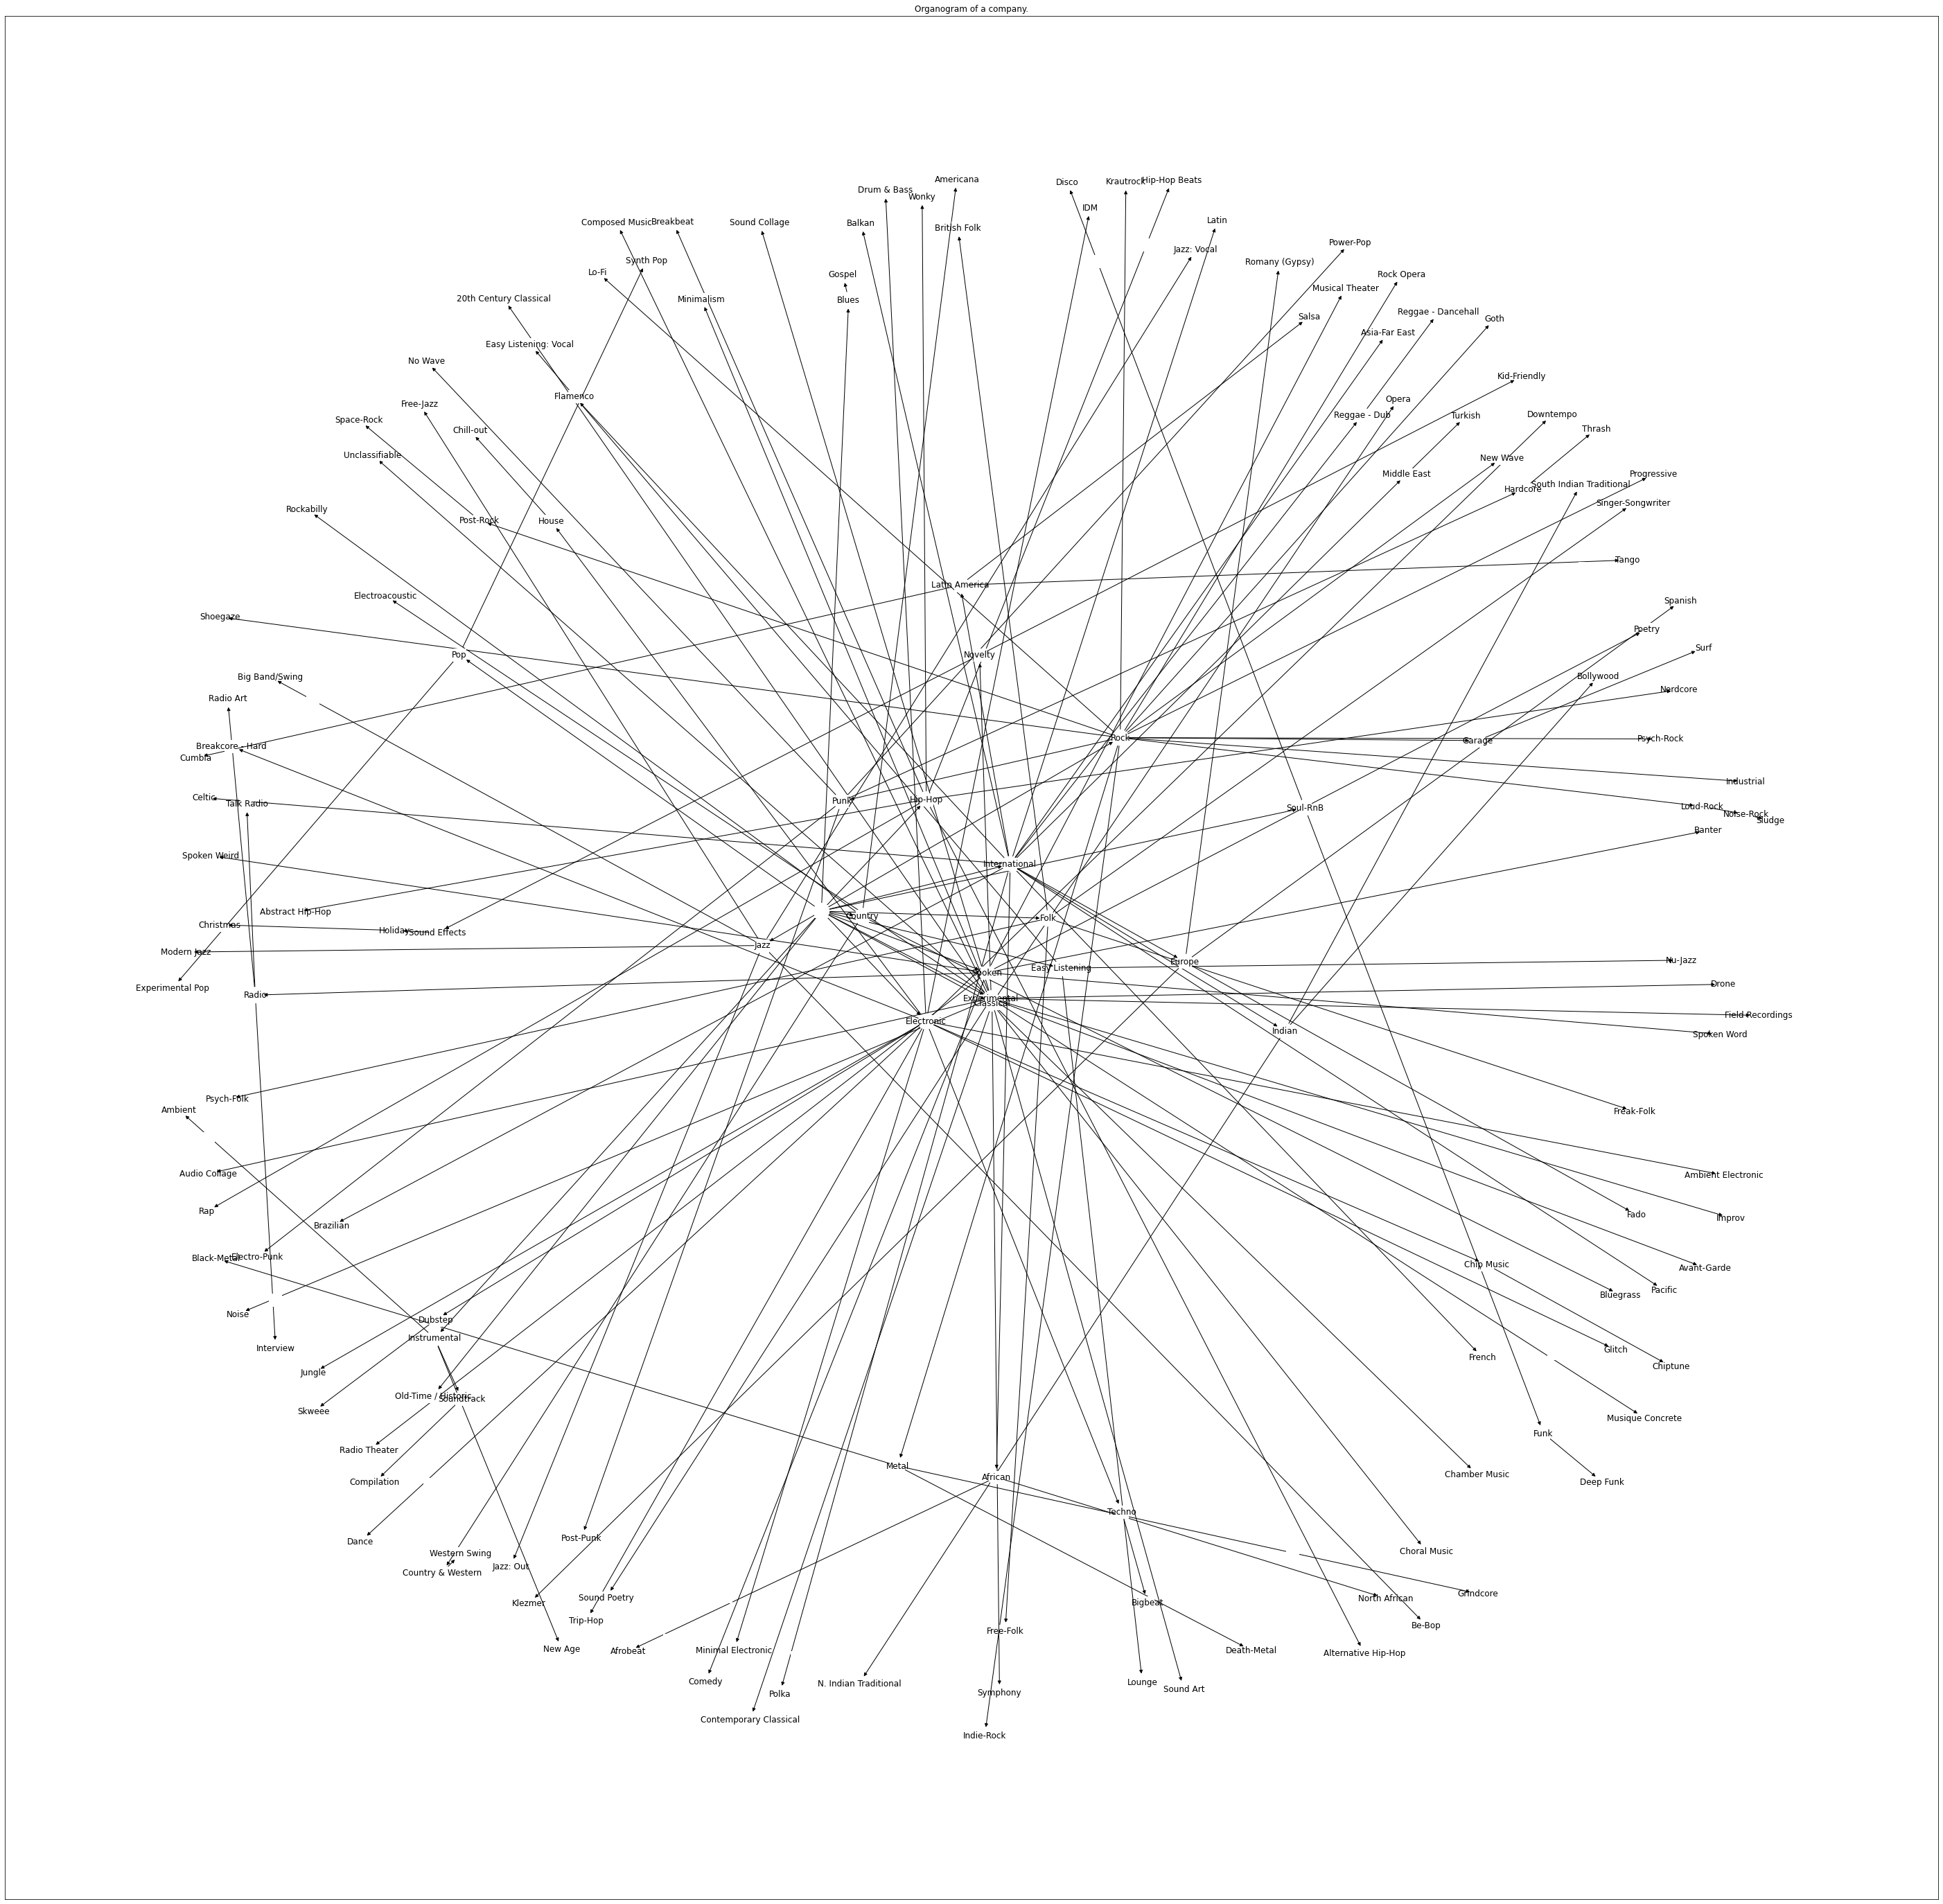

In [30]:
G = nx.DiGraph()
nodes = np.arange(0, genres.shape[0]).tolist()
G.add_nodes_from(nodes)
edges = []
for i, g in genres.groupby('parent'):
    edges += [(i, gg) for gg in g['genre_id']]
G.add_edges_from(edges)
labels = {}
for i, row in genres.iterrows():
    labels[row['genre_id']] = row['title']
fig = plt.figure(figsize=(50,50))
nx.draw_networkx(G,labels = labels, arrows = True,
 node_shape = "s", node_color = "white")
plt.title("Organogram of a company.")
plt.savefig("genre_tree_graph.jpeg", dpi = 300)
plt.show()

In [7]:
small = tracks[tracks['set', 'subset'] <= 'small']
small.head()

album                                                           \
         comments        date_created date_released engineer favorites  id   
track_id                                                                     
2               0 2008-11-26 01:44:45    2009-01-05      NaN         4   1   
5               0 2008-11-26 01:44:45    2009-01-05      NaN         4   1   
10              0 2008-11-26 01:45:08    2008-02-06      NaN         4   6   
140             1 2008-11-26 01:49:59    2007-05-22      NaN         1  61   
141             0 2008-11-26 01:49:57    2009-01-16      NaN         1  60   

                                                                     \
                                                information listens   
track_id                                                              
2                                                   <p></p>    6073   
5                                                   <p></p>    6073   
10                                                      NaN   47632   
140       <p>Alec K. Redfearn &amp; The Eyesores: Ellen ...    1300   
141       <p>A full ensamble of strings, drums, electron...    1304   

                                               ...       track           \
                                producer tags  ... information interest   
track_id                                       ...                        
2                                    NaN   []  ...         NaN     4656   
5                                    NaN   []  ...         NaN     1933   
10                                   NaN   []  ...         NaN    54881   
140       Alec K. Refearn, Rob Pemberton   []  ...         NaN     1593   
141                                  NaN   []  ...         NaN      839   

                                                                           \
         language_code                                            license   
track_id                                                                    
2                   en  Attribution-NonCommercial-ShareAlike 3.0 Inter...   
5                   en  Attribution-NonCommercial-ShareAlike 3.0 Inter...   
10                  en  Attribution-NonCommercial-NoDerivatives (aka M...   
140                 en  Attribution-Noncommercial-No Derivative Works ...   
141                 en  Attribution-Noncommercial-No Derivative Works ...   

                                                                     
         listens lyricist number publisher tags               title  
track_id                                                             
2           1293      NaN      3       NaN   []                Food  
5           1151      NaN      6       NaN   []          This World  
10         50135      NaN      1       NaN   []             Freeway  
140         1299      NaN      2       NaN   []  Queen Of The Wires  
141          725      NaN      4       NaN   []                Ohio  

[5 rows x 52 columns]

In [8]:
print('{} top-level genres'.format(len(genres['top_level'].unique())))
genres.loc[genres['top_level'].unique()].sort_values('#tracks', ascending=False)

16 top-level genres


,#tracks,parent,title,top_level
genre_id,,,,
38,38154,0,Experimental,38
15,34413,0,Electronic,15
12,32923,0,Rock,12
1235,14938,0,Instrumental,1235
10,13845,0,Pop,10
17,12706,0,Folk,17
21,8389,0,Hip-Hop,21
2,5271,0,International,2
4,4126,0,Jazz,4


In [32]:
small = tracks['set', 'subset'] <= 'small'
small_tracks = tracks[small]

In [37]:
audio_path = '../fma_small/'
wav_files = glob.glob('../fma_small/**/*.wav')
small_tracks['audio_path'] = small_tracks.index.map(lambda x: get_audio_path(audio_path, x)).values
small_tracks = small_tracks[small_tracks['audio_path'].isin(wav_files)]

In [38]:
train = small_tracks['set', 'split'] == 'training'
val = small_tracks['set', 'split'] == 'validation'
test = small_tracks['set', 'split'] == 'test'

train_tracks = small_tracks[train]
val_tracks = small_tracks[val]
test_tracks = small_tracks[test]

print(train_tracks.shape, val_tracks.shape, test_tracks.shape)

(6397, 53) (800, 53) (800, 53)


In [39]:
train_genres = train_tracks[('track', 'genre_top')].values
np.unique(train_genres)

array(['Electronic', 'Experimental', 'Folk', 'Hip-Hop', 'Instrumental',
       'International', 'Pop', 'Rock'], dtype=object)

In [43]:
train_tracks.to_parquet('data/train_tracks.parquet')
val_tracks.to_parquet('data/val_tracks.parquet')
test_tracks.to_parquet('data/test_tracks.parquet')

In [41]:

mp3_files = glob.glob('../fma_small/**/*.mp3')
for f in mp3_files:
    os.remove(f)

In [ ]:
train_tracks_.to_parquet('data/train_tracks.parquet')
val_tracks_.to_parquet('data/val_tracks.parquet')
test_tracks_.to_parquet('data/test_tracks.parquet')